In [1]:
import tensorflow as tf
import tensorflow.compat.v1 as tfc # needed if using Tensorflow v2, then tfc is v1
# https://stackoverflow.com/questions/53429896/how-do-i-disable-tensorflows-eager-execution
tfc.disable_eager_execution() # eager execution enabled by default in Tensorflow v2
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from scipy.optimize import minimize
import numpy as np

We consider the data of people applying for credit cards, and a banker has placed them in one of the following categories:

    Approved (1)
    
    Denied (-1)
    
Each data point has 16 associated features (found in credit_data.csv) and a corresponding label (found in credit_label.csv).
(# data = m = 653, # features = n = 16)

We consider the data for two cases: data is unchanged, and data is normalized by the maximum value of each feature. 

In [2]:
# Import data
# https://realpython.com/python-csv/
credit_data = np.loadtxt(open("credit_data.csv", "rb"), delimiter=",", skiprows=1)
credit_label = np.loadtxt(open("credit_label.csv", "rb"), delimiter=",", skiprows=1)

#designate training data
training_data = credit_data[0:500, :]
training_label = np.zeros([500,2])
#make one-hot labels (i.e. approved ~ [1,0], denied ~ [0,1])
for i in range(500):
    if credit_label[i]==1:
        training_label[i] = np.array([1,0])
    else:
        training_label[i] = np.array([0,1])

#designate testing data
test_data = credit_data[500:653, :]
test_label = np.zeros([153,2])
#make one-hot labels (i.e. approved ~ [1,0], denied ~ [0,1])
for i in range(153):
    if credit_label[i]==1:
        test_label[i] = np.array([1,0])
    else:
        test_label[i] = np.array([0,1])


Functions we'll need:

In [3]:
#define important functions
# Initializing the weights and biases to be randomly selected from a normal distribution with mean zero and standard deviation 1
# These have slightly positive initial bias to break symmetry
def weight_variable(shape):
    initial = tfc.random_normal(shape=shape, mean=0.0, stddev=1.0)
    return tfc.Variable(initial)

def bias_variable(neurons):
    initial = tfc.random_normal(shape = neurons, mean = 0.0, stddev = 1.0)
    return tfc.Variable(initial)

# https://stackoverflow.com/questions/40994583/how-to-implement-tensorflows-next-batch-for-own-data
# Return a total of `num` random samples and labels. 
# makes sure Net isn't dependent on ordering of points
def next_batch(num, data, labels):
    idx = np.arange(0 , np.shape(data)[0])
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i,:] for i in idx]
    labels_shuffle = [labels[i,:] for i in idx]
    
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)


# # Choose 5 random samples
# Xtr, Ytr = next_batch(5, training_data, training_label)
# print(Xtr)
# print(Ytr)

DATA UNCHANGED

We create an artificial neural network (ANN) model with 3 layers. 

 Layer 1: 30 neurons and linear transfer function for the activation function.
    
 Layer 2: 30 neurons and tanh function for the activation function. 
 
 Layer 3: (output layer) 2 neurons and softmax for the activation function.
 

For more on activation functions: https://www.tensorflow.org/api_docs/python/tf/nn

We train the 3 layer Neural Network by: 
1. Initializing the weights and biases to be randomly selected from a normal distribution with mean zero and standard deviation 1
2. Reshuffle the training data and pass through the 3 layers, then predict classes for each data point
3. Backprop. using the Gradient Descent Optimizer, which heads in the direction of largest gradient to minimize cross-entropy loss
4. Update the weights and biases
5. Pass the testing data through, and make predictions, then compute the accuracy
5. Repeat steps 2-5 for 1000 iterations.

We test the data every 100 iterations using the testing data. 

In [11]:
#start an interactive session
sess = tfc.InteractiveSession()

#tf.enable_eager_execution()


#placeholders for input images and 1 hot class vector
#inputs are 1x15 feature vector
#note that the shape is optional, but will allow us to catch bugs later
x = tfc.placeholder(tfc.float32, shape=[None, 15])
y_ = tfc.placeholder(tfc.float32, shape=[None, 2])


#define weights and biases, initialized as zeros for first hidden layer with 30 nodes
#note that the default is to save a variable as tf.float32
W_layer1 = weight_variable([15,30])
b_layer1 = bias_variable([30])


#define the class predictions
######## Activation relu 
h_layer1 = tfc.matmul(x,W_layer1) + b_layer1

#define weights and biases, initialized as zeros for second layer 
#note that the default is to save a variable as tf.float32
W_layer2 = weight_variable([30,30])
b_layer2 = bias_variable([30])

#define the class predictions
######## Activation tanh
h_layer2 = tfc.nn.tanh(tf.matmul(h_layer1,W_layer2) + b_layer2)

#define weights and biases, initialized as zeros for second layer 
#note that the default is to save a variable as tf.float32
W_layer3 = weight_variable([30,2])
b_layer3 = bias_variable([2])

#define the class predictions
######## Activation softmax
h_layer3 = tfc.nn.softmax(tfc.matmul(h_layer2,W_layer3) + b_layer3)

#define the cross entropy loss
#the cross entropy logits function applies a softmax on the model's unnormalized prediction and
#sums across all classes
#the reduce_mean function takes the average over the sums
cross_entropy = tfc.reduce_mean(tfc.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=h_layer3))

#define a training step, which you will run later with the train_step.run command
#train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
train_step = tfc.train.GradientDescentOptimizer(learning_rate = 0.1).minimize(cross_entropy)

# #define a true/false vector to evaluate predictions
correct_prediction = tfc.equal(tfc.argmax(h_layer3,1), tfc.argmax(y_,1))

# #recast the true/false vector as a binary vector and take the average
accuracy = tfc.reduce_mean(tfc.cast(correct_prediction, tfc.float32))


#add a tensorboard graph
writer = tfc.summary.FileWriter('./nn_graph', sess.graph)
# add a summary to store the accuracies
training_summary=tfc.summary.scalar('train_acc', accuracy)
testing_summary=tfc.summary.scalar('test_acc', accuracy)

#initialize all variables
sess.run(tfc.global_variables_initializer())
#np.random.seed(1)

train_accuracy = np.zeros(1001)
test_accuracy = np.zeros(1001)

#run 1000 iterations of SGD with batch size equal to 500
for i in range(1001):
    batch = next_batch(500, training_data , training_label)
    
    train_accuracy[i],summary = sess.run([accuracy,training_summary],feed_dict={x:batch[0], y_: batch[1]})
    writer.add_summary(summary, i)
    
    test_accuracy[i],summary = sess.run([accuracy,testing_summary],feed_dict={x: test_data , y_: test_label})
    writer.add_summary(summary, i)
    
    if i%50 == 0: #evaluate and print the training accuracy every 10 iterations
        print("step %d, training accuracy %g"%(i, train_accuracy[i]))
    if i%100 == 0: #evaluate and print the testing accuracy every 100 iterations
        print("test accuracy %g"%accuracy.eval(feed_dict={x: test_data, y_: test_label}))

    train_step.run(feed_dict={x: batch[0], y_: batch[1]})

sess.close()

step 0, training accuracy 0.53
test accuracy 0.366013
step 50, training accuracy 0.672
step 100, training accuracy 0.68
test accuracy 0.503268
step 150, training accuracy 0.68
step 200, training accuracy 0.68
test accuracy 0.503268
step 250, training accuracy 0.682
step 300, training accuracy 0.682
test accuracy 0.503268
step 350, training accuracy 0.676
step 400, training accuracy 0.676
test accuracy 0.503268
step 450, training accuracy 0.682
step 500, training accuracy 0.682
test accuracy 0.503268
step 550, training accuracy 0.682
step 600, training accuracy 0.68
test accuracy 0.542484
step 650, training accuracy 0.68
step 700, training accuracy 0.682
test accuracy 0.54902
step 750, training accuracy 0.684
step 800, training accuracy 0.684
test accuracy 0.54902
step 850, training accuracy 0.688
step 900, training accuracy 0.69
test accuracy 0.54902
step 950, training accuracy 0.69
step 1000, training accuracy 0.692
test accuracy 0.542484


Text(0.5, 1.0, 'Un-normalized data accuracy')

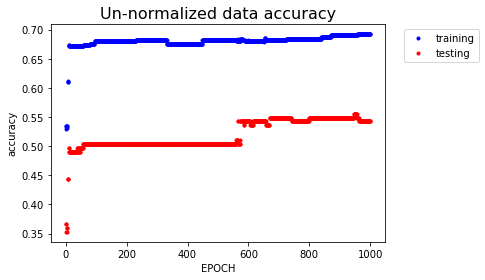

In [12]:
fig = plt.figure(figsize=(6,4))

#plt.plot(accuracies)

plt.plot( train_accuracy, '.b', label = 'training')
plt.plot( test_accuracy, '.r', label = 'testing')

axes = plt.gca()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
axes.set_xlabel('EPOCH')
axes.set_ylabel('accuracy')
plt.title('Un-normalized data accuracy', fontsize = 16)

DATA NORMALIZED

In [6]:
norm = np.amax(training_data[0:500,:],axis=0)

#normalize the data by the maximum value of each feature
norm_training = np.zeros((500,15))
norm_test = np.zeros((153,15))
for j in range(15):
    for i in range(500):
        norm_training[i,j] = training_data[i,j]/norm[j]
    for k in range(153):
        norm_test[k,j] = test_data[k,j]/norm[j]

Use same structure of ANN

Train using normalized data

In [7]:
# Activation functions: https://www.tensorflow.org/api_docs/python/tf/nn

#start an interactive session
sess = tfc.InteractiveSession()


#placeholders for input images and 1 hot class vector
#inputs are 1x15 feature vector
#note that the shape is optional, but will allow us to catch bugs later
x = tfc.placeholder(tfc.float32, shape=[None, 15])
y_ = tfc.placeholder(tfc.float32, shape=[None, 2])


#define weights and biases, initialized as zeros for first hidden layer with 30 nodes
#note that the default is to save a variable as tf.float32
W_layer1 = weight_variable([15,30])
b_layer1 = bias_variable([30])

#assign the initial values to all variables
sess.run(tfc.global_variables_initializer())

#define the class predictions
######## Activation relu 
h_layer1 = tfc.matmul(x,W_layer1) + b_layer1

#define weights and biases, initialized as zeros for second layer 
#note that the default is to save a variable as tf.float32
W_layer2 = weight_variable([30,30])
b_layer2 = bias_variable([30])

#define the class predictions
######## Activation tanh
h_layer2 = tfc.nn.tanh(tfc.matmul(h_layer1,W_layer2) + b_layer2)

#define weights and biases, initialized as zeros for second layer 
#note that the default is to save a variable as tf.float32
W_layer3 = weight_variable([30,2])
b_layer3 = bias_variable([2])

#define the class predictions
######## Activation softmax
h_layer3 = tfc.nn.softmax(tfc.matmul(h_layer2,W_layer3) + b_layer3)


#define the cross entropy loss
#the cross entropy logits function applies a softmax on the model's unnormalized prediction and sums across all classes
#the reduce_mean function takes the average over the sums
cross_entropy = tfc.reduce_mean(tfc.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=h_layer3))

#define a training step, which you will run later with the train_step.run command
#train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
train_step = tfc.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)

#define a true/false vector to evaluate predictions
correct_prediction = tfc.equal(tf.argmax(h_layer3,1), tf.argmax(y_,1))

#recast the true/false vector as a binary vector and take the average
accuracy = tfc.reduce_mean(tfc.cast(correct_prediction, tf.float32))

#add a tensorboard graph
writer = tfc.summary.FileWriter('./norm_nn_graph', sess.graph)
# add a summary to store the accuracies
training_summary=tfc.summary.scalar('train_acc', accuracy)
testing_summary=tfc.summary.scalar('test_acc', accuracy)


#initialize all variables
sess.run(tfc.global_variables_initializer())
np.random.seed(1)

train_accuracy = np.zeros(1001)
test_accuracy = np.zeros(1001)

#run 1000 iterations of SGD with batch size equal to 500
for i in range(1001):
    batch = next_batch(500, norm_training, training_label)
    
    train_accuracy[i],summary = sess.run([accuracy,training_summary],feed_dict={x:batch[0], y_: batch[1]})
    writer.add_summary(summary, i)
    
    test_accuracy[i],summary = sess.run([accuracy,testing_summary],feed_dict={x: norm_test, y_: test_label})
    writer.add_summary(summary, i)
    
    if i%50 == 0: #evaluate and print the training accuracy every 10 iterations
        print("step %d, training accuracy %g"%(i, train_accuracy[i]))
    if i%100 == 0: #evaluate and print the testing accuracy every 100 iterations
        print("test accuracy %g"%accuracy.eval(feed_dict={x: norm_test, y_: test_label}))

    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    
sess.close()

step 0, training accuracy 0.512
test accuracy 0.281046
step 50, training accuracy 0.524
step 100, training accuracy 0.718
test accuracy 0.48366
step 150, training accuracy 0.792
step 200, training accuracy 0.824
test accuracy 0.620915
step 250, training accuracy 0.852
step 300, training accuracy 0.862
test accuracy 0.647059
step 350, training accuracy 0.88
step 400, training accuracy 0.884
test accuracy 0.647059
step 450, training accuracy 0.888
step 500, training accuracy 0.894
test accuracy 0.666667
step 550, training accuracy 0.896
step 600, training accuracy 0.902
test accuracy 0.660131
step 650, training accuracy 0.904
step 700, training accuracy 0.904
test accuracy 0.660131
step 750, training accuracy 0.904
step 800, training accuracy 0.908
test accuracy 0.660131
step 850, training accuracy 0.908
step 900, training accuracy 0.908
test accuracy 0.660131
step 950, training accuracy 0.908
step 1000, training accuracy 0.908
test accuracy 0.666667


Text(0.5, 1.0, 'Normalized data accuracy')

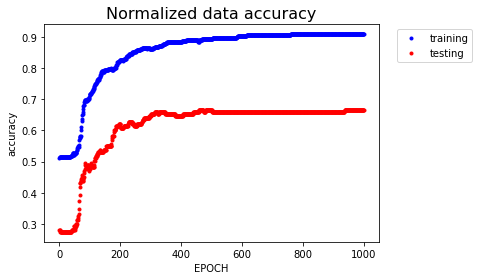

In [8]:
fig = plt.figure(figsize=(6,4))

#plt.plot(accuracies)

plt.plot( train_accuracy, '.b', label = 'training')
plt.plot( test_accuracy, '.r', label = 'testing')

axes = plt.gca()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
axes.set_xlabel('EPOCH')
axes.set_ylabel('accuracy')
plt.title('Normalized data accuracy', fontsize = 16)

Compare the accuracy of the final iterations:

Un-normalized, 
$$(\% accuracy)_{train} = 69.2\%$$
$$(\% accuracy)_{test} = 54.2\%$$
Normalized,
$$(\% accuracy)_{train} = 90.8\%$$
$$(\% accuracy)_{test} = 66.6\%$$
We can observe that the normalized data has a much better percent accuracy than the un-normalized case. 
Additionally, from the Accuracy plots the updating of accuracies is a much smoother process with the normalized data. 

Recall with the Perceptron model on the same data, we had accuracies of:

Un-normalized, 
$$(\% accuracy)_{train} = 64.8\%$$
$$(\% accuracy)_{test} = 68.0\%$$
Normalized,
$$(\% accuracy)_{train} = 77.0\%$$
$$(\% accuracy)_{test} = 81.7\%$$
So we observe that in both cases, the training accuracies have increased by using a Neural Network. Although, now the testing accuracies have decreased, and are lower than the training accuracy. Because they are close, it's a good sign that we're not overfitting the data. In other words, we can apply our network to new data the network hasn't seen before, and it will perform fairly well. 